# Market generator

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

import base
import market_generator_NDF
from utils import tosig

C:\Users\josep\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\josep\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\josep\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\josep\AppData\Local\Conti

In [11]:
# Signature order
order = 4

## Load monthly paths

In [10]:
import pandas_datareader as pdr
pdr.get_data_yahoo('USDKRW%3DX', datetime.date(2018, 1, 1), datetime.date(2019, 1, 1))["Close"]

Date
2018-01-01    1066.069946
2018-01-02    1065.219971
2018-01-03    1062.540039
2018-01-04    1063.939941
2018-01-05    1061.079956
2018-01-08    1060.500000
2018-01-09    1067.689941
2018-01-10    1071.739990
2018-01-11    1069.670044
2018-01-12    1065.140015
2018-01-15    1055.800049
2018-01-16    1061.819946
2018-01-17    1062.459961
2018-01-18    1066.560059
2018-01-19    1069.689941
2018-01-22    1066.359985
2018-01-23    1068.810059
2018-01-24    1072.760010
2018-01-25    1064.400024
2018-01-26    1064.890015
2018-01-29    1063.130005
2018-01-30    1069.790039
2018-01-31    1072.540039
2018-02-01    1069.020020
2018-02-02    1071.180054
2018-02-05    1090.010010
2018-02-06    1093.300049
2018-02-07    1079.260010
2018-02-08    1089.420044
2018-02-09    1095.859985
                 ...     
2018-11-22    1137.310059
2018-11-23    1135.500000
2018-11-26    1133.500000
2018-11-27    1129.030029
2018-11-28    1130.369995
2018-11-29    1121.119995
2018-11-30    1117.020020
2018-12

In [57]:
# ^GSPC is S&P 500.
#ticker = "^GSPC"
ticker = "USDKRW%3DX"
MG = market_generator_NDF.MarketGenerator(ticker, start=datetime.date(1980, 1, 1),
                                      freq="M", sig_order=order)

Computing log-signatures:   0%|          | 0/182 [00:00<?, ?it/s]

## Plot paths

In [38]:
np.shape(MG.conditions)

(522, 8)

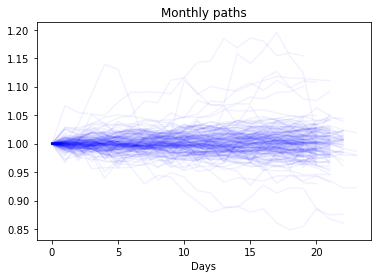

In [58]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [59]:
MG.train(n_epochs=10000)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [41]:
MG.conditions

array([[9.99990000e-01, 9.99990000e-01, 1.00000000e-05, ...,
        9.72766342e-01, 9.99990000e-01, 7.96819386e-01],
       [7.66943178e-01, 7.66943178e-01, 8.02724824e-01, ...,
        9.46655303e-01, 5.30699318e-01, 7.92453763e-01],
       [4.68524311e-01, 4.68524311e-01, 5.95036093e-01, ...,
        8.20117343e-01, 4.41351271e-01, 6.17669996e-01],
       ...,
       [5.27360703e-01, 5.27360703e-01, 9.83111308e-01, ...,
        9.72671280e-01, 5.34038681e-01, 7.96562410e-01],
       [4.30873187e-01, 4.30873187e-01, 9.86064746e-01, ...,
        9.72840686e-01, 5.34187324e-01, 7.96824926e-01],
       [4.53390709e-01, 4.53390709e-01, 9.95192793e-01, ...,
        9.72767011e-01, 5.34113048e-01, 7.96822676e-01]])

## Generate

In [60]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 36.39it/s]


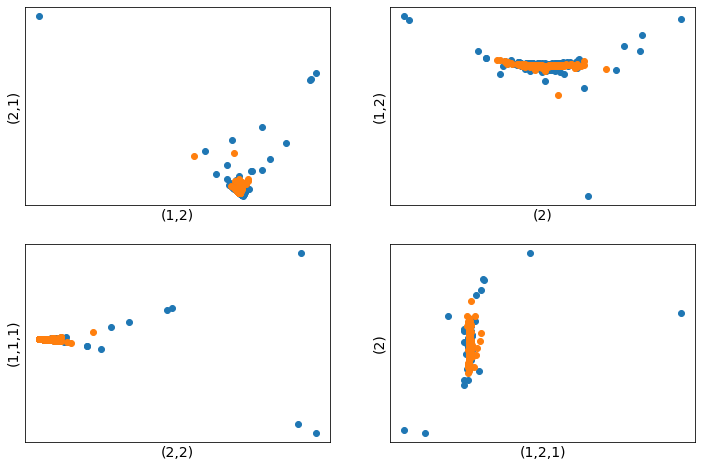

In [61]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [62]:
import process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

100%|████████████████████████████████████████████████████████████████████████████████| 181/181 [00:10<00:00, 17.85it/s]


Computing signatures of population 1:   0%|          | 0/181 [00:00<?, ?it/s]

Computing signatures of population 2:   0%|          | 0/181 [00:00<?, ?it/s]

Are the generated and real distributions DIFFERENT? False


## Invert log-signature

In [67]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])

In [68]:
logsig

array([ 1.8510172e+01,  1.9044638e+01, -8.2204071e+02,  7.6105942e+03,
        6.3453882e+03, -1.7113748e+05, -1.8774080e+05, -1.5708228e+05],
      dtype=float32)

In [69]:
pip = 0.01
n_pips = 10 * 100 # 50$
n_points = 21

n_iterations = 100
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

  0%|          | 0/100 [00:00<?, ?it/s]

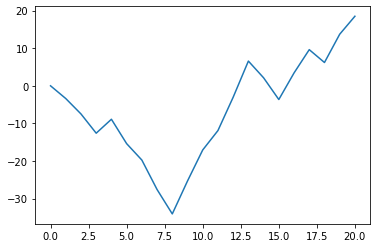

Target log-signature: [18.51017189025879, 19.04463768005371, -822.0407104492188, 7610.59423828125, 6345.38818359375, -171137.484375, -187740.796875, -157082.28125]
Recovered log-signature: [18.51, 18.51, -404.36105, 7612.417100250001, 7201.7712647499975, -102285.80997311331, -198138.14800087115, -97699.6248593483]


In [70]:
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [71]:
MG.conditions

array([[0.48539076, 0.48539076, 0.99098258, ..., 0.99925183, 0.99688548,
        0.9961918 ],
       [0.45239401, 0.45239401, 0.97341016, ..., 0.9989751 , 0.99665483,
        0.99596522],
       [0.54307227, 0.54307227, 0.97110669, ..., 0.99916732, 0.99687965,
        0.99610947],
       ...,
       [0.57090527, 0.57090527, 0.99021552, ..., 0.9993252 , 0.99696098,
        0.99625427],
       [0.44647479, 0.44647479, 0.98823253, ..., 0.99937632, 0.99701987,
        0.99630158],
       [0.50465995, 0.50465995, 0.99357169, ..., 0.99931146, 0.99693667,
        0.99623638]])

In [72]:
paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    paths.append(recovered_path)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
MG.windows[:20]

[array([[1455.2199707 , 1455.2199707 ],
        [1455.2199707 , 1399.42004395],
        [1399.42004395, 1399.42004395],
        [1399.42004395, 1402.10998535],
        [1402.10998535, 1402.10998535],
        [1402.10998535, 1403.44995117],
        [1403.44995117, 1403.44995117],
        [1403.44995117, 1441.4699707 ],
        [1441.4699707 , 1441.4699707 ],
        [1441.4699707 , 1457.59997559],
        [1457.59997559, 1457.59997559],
        [1457.59997559, 1438.56005859],
        [1438.56005859, 1438.56005859],
        [1438.56005859, 1432.25      ],
        [1432.25      , 1432.25      ],
        [1432.25      , 1449.68005371],
        [1449.68005371, 1449.68005371],
        [1449.68005371, 1465.15002441],
        [1465.15002441, 1465.15002441],
        [1465.15002441, 1455.14001465],
        [1455.14001465, 1455.14001465],
        [1455.14001465, 1455.90002441],
        [1455.90002441, 1455.90002441],
        [1455.90002441, 1445.56994629],
        [1445.56994629, 1445.56994629],


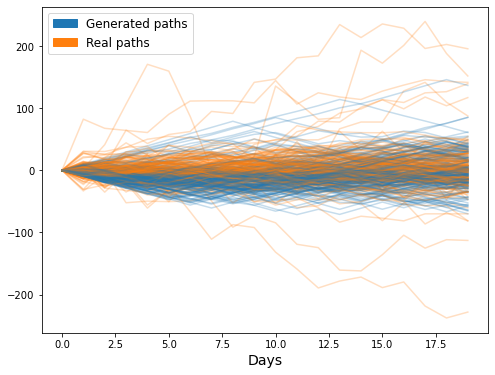

In [73]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(paths, MG.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)
plt.xlabel("Days", fontsize=14) 
plt.show()

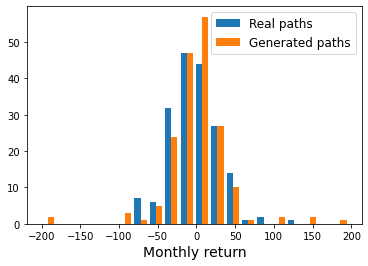

In [74]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [21]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

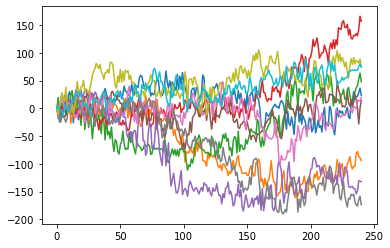

In [22]:
idx = 220

condition = MG.conditions[idx]

paths = [concatenate(condition, 12) for _ in range(10)]

plt.plot(np.transpose(paths))
plt.show()

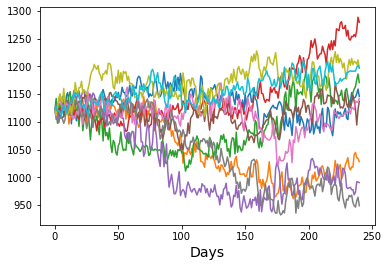

In [23]:
plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths))
plt.xlabel("Days", fontsize=14) 
plt.show()